## Weather Multi-Class Classification with MobileViT

[Korean](01_garbage.ko-KR.ipynb) \| [English](01_garbage.en-US.ipynb) \| Copyright (c) 2023 [Jihoon Lucas Kim](https://github.com/kimnamu)

<a href="https://colab.research.google.com/github/kimnamu/cvnets/blob/master/demo/classfication/01_garbage.ko-KR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

이 notebook은 Custom Dataset으로 Image Classification 모델을 학습하는 과정을 다루고 있습니다.


## Process
1. Scoping : 문제정의
2. Data : 데이터 수집, 분석
3. Modeling : 적합한 모델 선정
4. Training : 데이터 학습
5. Analysis : 모델 분석 및 평가

## 1. Scoping (문제 정의)

- Garbage Image가 주어졌을 때 해당 Image가 어떤 Garbage인지를 분류합니다.
  - Input : Image File
  - Output : Garbage Class

## 2. Data (데이터 수집 및 분석)
- 데이터 수집은 최초 한번으로 끝나는 것이 아닌 이후 모델링, 학습, 평가 기간동안 계속해서 염두해야 합니다.
- 데이터 분석은 정량적, 정성적으로 살펴보아야 합니다.

### 2.1. Summary

- Dataset Download : https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
- Dataset Tree
    ```
        weather
        ├─raw
        │ ├─Cloudy  : 300 files
        │ ├─Rain    : 213 files
        │ ├─Shine   : 253 files
        │ └─Sunrise : 356 files
        ...
    (Data Preprocessing)
        ├─train
        │ ├─Cloudy  : 209 files
        │ ├─Rain    : 150 files
        │ ├─Shine   : 176 files
        │ └─Sunrise : 250 files
        ├─val
        │ ├─Cloudy  : 43 files
        │ ├─Rain    : 30 files
        │ ├─Shine   : 41 files
        │ └─Sunrise : 54 files
        └─test
          ├─Cloudy  : 48 files
          ├─Rain    : 33 files
          ├─Shine   : 36 files
          └─Sunrise : 52 files
    ```
- Dataset Configuration
    - The number of images : 1122 files
    - The number of classes : 4
        - Cloudy, Rain, Shine, Sunrise
    - Average number of images per class : 280.5 files / class

### 2.2. Data Analysis

실제 데이터에 어떤 이미지가 있는지 살펴봅니다.

(Optional) gdrive에 있는 데이터를 mount 할때 아래와 같이 mount 후 데이터 경로를 지정해줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dir_main = "/content/gdrive/MyDrive/dataset/weather/"

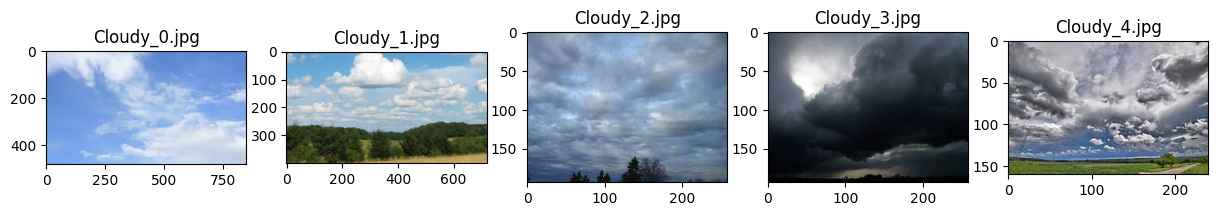

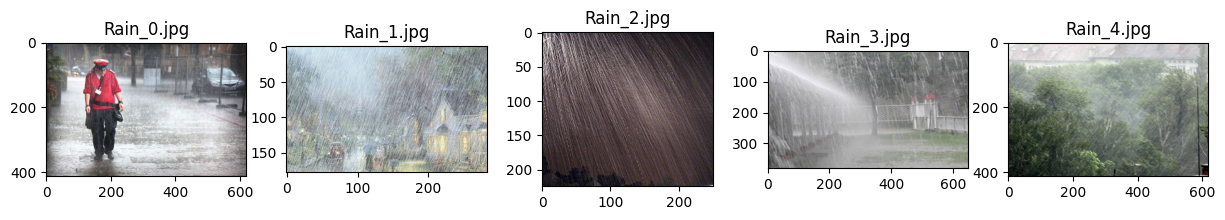

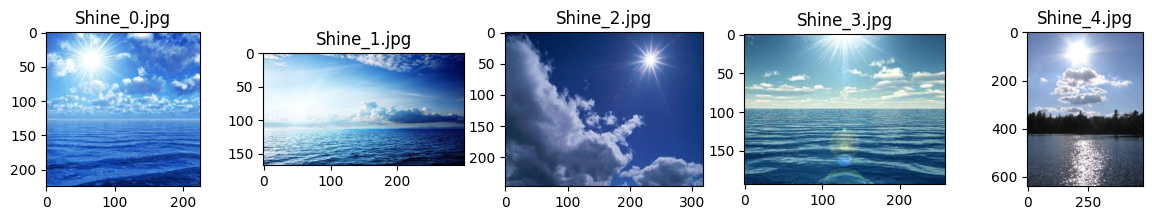

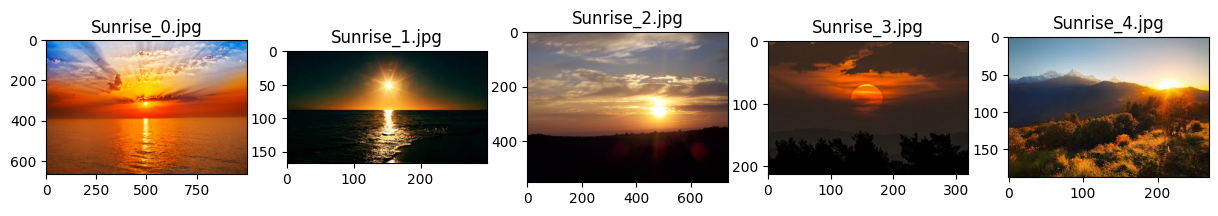

In [ ]:
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

dir_main = "../../../data/weather/"
source = "raw"
classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

n_show = 5
for cls in classes:
    image_paths = glob(f"{os.path.join(dir_main, source, cls, '*.jpg')}")
    images = [Image.open(image_path) for image_path in image_paths[:n_show]]

    fig, axes = plt.subplots(nrows=1, ncols=n_show, figsize=(15,2))
    for idx, img in enumerate(images):
        axes[idx].set_title(f"{cls}_{idx}.jpg")
        axes[idx].imshow(img)

### 2.3. Preprocessing dataset for train, validation and test

#### Preprare the dataset

In [ ]:
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
np.random.seed(724)

dir_main = "../../../data/weather/"
dir_data_original = os.path.join(dir_main, 'raw')
class_info = {idx : os.path.basename(cls) for idx, cls in enumerate(classes)}

img_files = glob(f"{dir_data_original}/*/*.jpg")
dataset = np.array([[img_file, img_file.split("/")[-2]] for img_file in img_files])

x = dataset[:,0]
y = dataset[:,1]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=724)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size=0.5, random_state=724)

In [ ]:
def create_symlink(x_target, name='train'):
    for x in x_target:
        src = os.path.abspath(x)
        dst = src.replace("raw", name)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        if not os.path.exists(dst):
            os.symlink(src, dst)

create_symlink(x_train, "train")
create_symlink(x_test, "test")
create_symlink(x_val, "val")

def get_numbers(ys, cls=None):
    cls_cnt = {}
    for y in ys:
        if y not in cls_cnt.keys():
            cls_cnt[y]=0
        cls_cnt[y]+=1
    if cls is None:
        return cls_cnt
    return cls_cnt[cls]

print(f"Class\t\tTrain\tVal\tTest\n")
for cls in class_info.values():
    print(f"{cls:10}\t{get_numbers(y_train, cls)}\t{get_numbers(y_val, cls)}\t{get_numbers(y_test, cls)}")

Class		Train	Val	Test

Cloudy    	209	43	48
Rain      	150	30	33
Shine     	176	41	36
Sunrise   	250	54	52


### 2.4. Create DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset
from glob import glob

class WeatherDataset(Dataset): 
    def __init__(self, dir_dataset, tr):
        self.dir_dataset = os.path.abspath(dir_dataset)
        self.filelist = glob(self.dir_dataset + '/*/*.jpg')
        assert len(self.filelist)!=0, f"{self.dir_dataset + '/*/*.jpg'} is empty"
        self.classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
        self.tr = tr

    def get_image(self, filename):
        img = Image.open(filename).convert("RGB")

        exif = img.getexif()
        orientation = exif.get(0x0112)
        transpose_method = {
            2: Image.Transpose.FLIP_LEFT_RIGHT,
            3: Image.Transpose.ROTATE_180,
            4: Image.Transpose.FLIP_TOP_BOTTOM,
            5: Image.Transpose.TRANSPOSE,
            6: Image.Transpose.ROTATE_270,
            7: Image.Transpose.TRANSVERSE,
            8: Image.Transpose.ROTATE_90,
        }.get(orientation)

        if transpose_method is not None:
            img = img.transpose(transpose_method)
        img = self.tr(img)
        return img

    def get_label(self, filename):
        label = np.array([0] * len(self.classes))
        cls = filename.split('/')[-2]
        label[self.classes.index(cls)] = 1
        return torch.from_numpy(label).type(torch.FloatTensor)


    def __getitem__(self, idx):
        filename = self.filelist[idx]
        img = self.get_image(filename)
        label = self.get_label(filename)
        return img, label

    def __len__(self): 
        return len(self.filelist)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

# print(model.default_cfg['mean']) # 'mean': (0.485, 0.456, 0.406)
# print(model.default_cfg['std']) # 'std': (0.229, 0.224, 0.225)
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_tr = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

test_tr = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])
train_ds = WeatherDataset(os.path.join(dir_main, "train"), train_tr)
val_ds = WeatherDataset(os.path.join(dir_main, "val"), test_tr)
test_ds = WeatherDataset(os.path.join(dir_main, "test"), test_tr)

train_dl = DataLoader(train_ds, shuffle=True, num_workers=0, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=True, num_workers=0, batch_size=64)
test_dl = DataLoader(test_ds, shuffle=True, num_workers=0, batch_size=64)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### 3. Modeling

#### 3.1. Select Model - Vision Transformer

MobileViT: Light-weight, General-purpose, and Mobile-friendly Vision Transformer ([Paper](https://arxiv.org/abs/2110.02178)) 이란?
MobileViT (Mobile Vision Transformer)은 경량화된 모바일 기기에서도 효율적으로 실행 가능한 Vision Transformer 기반의 이미지 분류 모델입니다. 

MobileViT의 전신이 되는 Vision Transformer의 특징을 먼저 살펴보도록 하겠습니다.

<center><img src = "https://drive.google.com/uc?id=1Ir6hm-UtAuKWuyyrHu86CA2iQ_cUwGkD"  height = 300> </center>

1. Vision Transformer는 이미지 분류에 대한 전통적인 CNN 기반 모델 대신 self-attention mechanism을 사용하는 새로운 딥러닝 모델입니다. 이 모델은 이전에 자연어 처리에서 널리 사용되어 온 transformer 구조를 영상 처리에 적용한 것입니다. 이 모델의 특징은 다음과 같습니다:

2. Self-attention mechanism : Vision Transformer 모델은 각 이미지 패치를 처리하기 위해 self-attention mechanism을 사용합니다. 이는 입력 이미지를 작은 패치로 분할하고, 이러한 패치를 입력으로 사용하여 transformer encoder에서 self-attention을 수행합니다. 이렇게 함으로써 이미지의 각 패치가 서로 다른 패치와 어떻게 상호 작용하는지에 대한 정보를 효과적으로 모델링할 수 있습니다.

3. 이미지 분할 : Vision Transformer 모델은 입력 이미지를 작은 패치로 분할합니다. 이를 통해 모델은 전체 이미지를 한 번에 처리하는 대신, 각 패치를 독립적으로 처리할 수 있습니다. 이러한 방식은 모델의 계산 복잡도를 줄이면서도 이미지의 전체적인 구조를 보존할 수 있습니다. 또한, 이 모델은 다른 모델 아키텍처와 함께 사용될 수 있으며, 효과적인 전이 학습을 통해 다른 분야에서 사용될 수 있습니다.

4. 모듈러 구조 : Vision Transformer 모델은 transformer encoder와 MLP (Multi-Layer Perceptron) decoder로 구성됩니다. 이 모듈러 구조를 사용하여, 모델을 더 쉽게 수정하고 조정할 수 있습니다.

<center><img src = "https://drive.google.com/uc?id=14bTmSsBBwI_cpJUgm6FWHrqb7wH5yaP0"  height = 300> </center>

MobileViT는 ViT(Vision Transformer)와의 차이를 통해 좀더 살펴보겠습니다. 우선 두 모델 모두 Transformer 아키텍처를 기반으로 한 딥러닝 모델입니다. 하지만 MobileViT은 모바일 기기에서도 빠르고 경량화된 실행이 가능하도록 최적화된 구조를 가지고 있습니다. 이에 비해 ViT는 컴퓨팅 리소스가 더 많은 환경에서 높은 성능을 발휘합니다.

1. MobileViT Block: MobileViT은 ViT에서 사용되는 큰 어텐션 헤드를 작은 어텐션 헤드로 대체하여 모델의 크기를 줄이고, Depthwise Separable Convolution과 Pointwise Convolution 등의 경량화된 레이어를 사용하여 모바일 기기에서도 빠른 실행이 가능하도록 최적화된 구조를 가지고 있습니다.

    <center><img src = "https://drive.google.com/uc?id=1zEwazHYt1L1HELemzTx9f9uwPtUpJur8"  height = 300> </center>

    - Depthwise Separable Convolution Block: 이 블록은 입력 데이터를 Depthwise Separable Convolution(깊이별 분리 합성곱)을 통해 처리합니다. Depthwise Separable Convolution은 컨볼루션 연산을 Depthwise Convolution(깊이별 합성곱)과 Pointwise Convolution(점별 합성곱)으로 분리하여 연산량을 크게 줄일 수 있는 방법입니다. 이를 통해 모델의 크기와 실행 속도를 줄일 수 있습니다.

    - Self-Attention Block: 이 블록은 입력 데이터에 Self-Attention 메커니즘을 적용합니다. Self-Attention은 입력 시퀀스에서 각 요소들 간의 상호작용을 고려하여 정보를 추출하는 메커니즘입니다. 이를 통해 입력 데이터의 중요한 부분에 집중하고, 불필요한 정보를 제거하여 모델의 성능을 개선할 수 있습니다.

    <center><img src = "https://drive.google.com/uc?id=1gBK9jneRRMc8bIA2s7KvP4fpu6dezqT1"  height = 300> </center>

2. 메모리 효율: MobileViT는 ViT와 비교하여 모델의 크기가 작고, 경량화된 구조를 가지기 때문에 더 적은 컴퓨팅 리소스를 사용하여 실행할 수 있습니다. 이에 따라 모바일 기기에서도 높은 성능을 발휘할 수 있습니다. 하지만 ViT는 모델의 크기가 크고, 보다 복잡한 구조를 가지기 때문에 더 높은 성능을 보입니다. 따라서, MobileViT는 모바일 기기에서 경량화된 실행이 가능하도록 최적화된 모델이며, ViT는 더 큰 컴퓨팅 리소스에서 높은 성능을 발휘할 수 있는 모델입니다.

    <center><img src = "https://drive.google.com/uc?id=1GdQKpip31KRTnaZ-1H59StTMDe3z01w0"  height = 300> </center>

3. 다양한 데이터셋에서 우수한 성능: MobileViT은 다양한 이미지 분류 데이터셋에서 우수한 성능을 보입니다. 예를 들어, ImageNet 데이터셋에서 MobileViT-Slim은 Top-1 정확도 77.1%, MobileViT-Lite는 Top-1 정확도 73.6%를 달성하였습니다. 이는 경량화된 모델임에도 불구하고, 대부분의 모델 크기가 큰 Vision Transformer 모델들보다 높은 성능을 보인다는 것을 의미합니다.


#### 3.2. Package Installation

아래 package를 설치 합니다.
- [timm](https://github.com/rwightman/pytorch-image-models), [opencv](https://github.com/opencv/opencv-python), [sklearn](https://scikit-learn.org/stable/index.html)

```
    # install dependancy
    pip install timm
    pip install opencv-python
    pip install scikit-learn
    # pip install -r requirements.txt
```

#### 3.3. Loading Model

Timm에는 기존에 학습된 여러 pretrained 모델을 제공합니다.

In [ ]:
import timm

print(f"The number of pretrained models : {len(timm.list_models('*', pretrained=True))}")
timm.list_models('mobilevit*', pretrained=True)

The number of pretrained models : 770


['mobilevit_s',
 'mobilevit_xs',
 'mobilevit_xxs',
 'mobilevitv2_050',
 'mobilevitv2_075',
 'mobilevitv2_100',
 'mobilevitv2_125',
 'mobilevitv2_150',
 'mobilevitv2_150_384_in22ft1k',
 'mobilevitv2_150_in22ft1k',
 'mobilevitv2_175',
 'mobilevitv2_175_384_in22ft1k',
 'mobilevitv2_175_in22ft1k',
 'mobilevitv2_200',
 'mobilevitv2_200_384_in22ft1k',
 'mobilevitv2_200_in22ft1k']

In [ ]:
model = timm.create_model('mobilevitv2_100', pretrained=True)
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-mvit-weights/mobilevitv2_100-e464ef3b.pth',
 'num_classes': 1000,
 'input_size': (3, 256, 256),
 'pool_size': (8, 8),
 'crop_pct': 0.888,
 'interpolation': 'bicubic',
 'mean': (0.0, 0.0, 0.0),
 'std': (1.0, 1.0, 1.0),
 'first_conv': 'stem.conv',
 'classifier': 'head.fc',
 'fixed_input_size': False,
 'architecture': 'mobilevitv2_100'}

In [ ]:
model = timm.create_model('mobilevitv2_100', pretrained=True, num_classes=len(classes), global_pool='avg')
model.eval()
model(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 4])

In [ ]:
import timm
from torch import nn
import torch.nn.functional as F

class MobileViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('mobilevitv2_100', pretrained=True, num_classes=len(classes), global_pool='avg')
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = MobileViT()
# to_device(model, device)

In [ ]:
import pickle
import os

class TrainHelper():
    def __init__(self, save_path='./ckpt/history.pickle', history=[]):
        self.history = history
        self.save_path = save_path
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    def accuracy(self, outputs, labels):
        pred = torch.max(outputs, dim=1)[1]
        gt = torch.max(labels, dim=1)[1]
        return torch.tensor(torch.sum(pred == gt).item() / len(pred))

    @torch.no_grad()
    def validation(self, batch):
        images, labels = batch 
        out = model(images)
        acc = self.accuracy(out, labels)
        loss = F.cross_entropy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    @torch.no_grad()
    def evaluation(self, model, data_loader):
        model.eval()
        outputs = [self.validation(batch) for batch in data_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': round(epoch_loss.item(), 5), 'val_acc': round(epoch_acc.item(), 5)}

    def logging(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        self.history.append(result)
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

train_helper = TrainHelper()

In [ ]:
train_helper.evaluation(model, val_dl)

{'val_loss': 1.38737, 'val_acc': 0.24375}

## 4.Training

In [ ]:
from tqdm import tqdm

epochs = 5
optimizer = torch.optim.Adam(model.parameters(), 5.5e-5)
val_acc_best = 0
save_model_path = "./ckpt/"
os.makedirs(save_model_path, exist_ok=True)
for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    for batch in tqdm(train_dl):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)

        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    result = train_helper.evaluation(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()

    # Save the best model
    if result['val_acc'] >= val_acc_best:
        val_acc_best = result['val_acc']
        if 'save_model_name' in locals() and os.path.exists(save_model_name):
            os.remove(save_model_name)
        save_model_name = os.path.join(save_model_path, f"best_ep_{epoch}_{val_acc_best}.pt")
        torch.save(model.state_dict(), save_model_name)
        print(f"Saved PyTorch Model State to {save_model_name}")

    train_helper.logging(epoch, result)

# Save the last model
save_model_name = os.path.join(save_model_path, f"last_ep_{epoch}_{val_acc_best}.pt")
torch.save(model.state_dict(), save_model_name)

100%|██████████| 13/13 [02:59<00:00, 13.82s/it]


Saved PyTorch Model State to ./ckpt/best_ep_0_0.50208.pt
Epoch 0: train_loss: 1.3807, val_loss: 1.3761, val_acc: 0.5021


100%|██████████| 13/13 [02:11<00:00, 10.15s/it]


Saved PyTorch Model State to ./ckpt/best_ep_1_0.77292.pt
Epoch 1: train_loss: 1.3654, val_loss: 1.3585, val_acc: 0.7729


100%|██████████| 13/13 [01:58<00:00,  9.15s/it]


Saved PyTorch Model State to ./ckpt/best_ep_2_0.91771.pt
Epoch 2: train_loss: 1.3496, val_loss: 1.3383, val_acc: 0.9177


100%|██████████| 13/13 [02:07<00:00,  9.77s/it]


Saved PyTorch Model State to ./ckpt/best_ep_3_0.95.pt
Epoch 3: train_loss: 1.3263, val_loss: 1.3151, val_acc: 0.9500


100%|██████████| 13/13 [02:14<00:00, 10.34s/it]


Saved PyTorch Model State to ./ckpt/best_ep_4_0.95729.pt
Epoch 4: train_loss: 1.2985, val_loss: 1.2813, val_acc: 0.9573


##### Train & Validation Losses

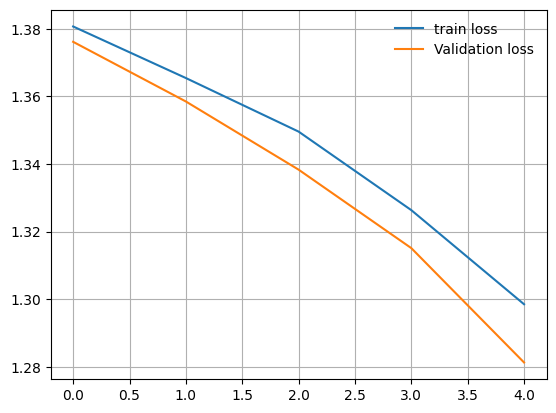

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = [history['train_loss'] for history in train_helper.history]
val_loss = [history['val_loss'] for history in train_helper.history]

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.legend(frameon=False)

##### Accuracy

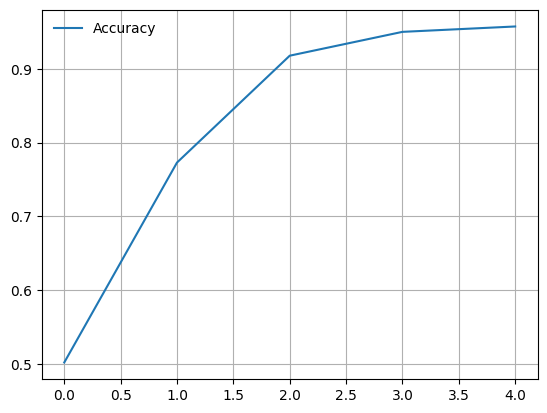

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

val_acc = [history['val_acc'] for history in train_helper.history]
plt.plot(val_acc, label='Accuracy')
plt.grid()
plt.legend(frameon=False)

## 5. Analysis

##### Confusion Matrix

100%|██████████| 3/3 [00:18<00:00,  6.26s/it]

Classes : ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Performance 
              precision    recall  f1-score   support

           0      0.882     0.938     0.909        48
           1      0.941     0.970     0.955        33
           2      0.933     0.778     0.848        36
           3      0.963     1.000     0.981        52

    accuracy                          0.929       169
   macro avg      0.930     0.921     0.923       169
weighted avg      0.930     0.929     0.927       169



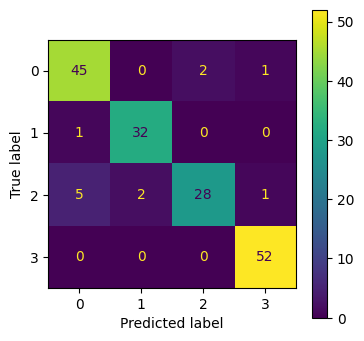

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

model.eval()

y_pred = []
y_true = []
for batch in tqdm(test_dl):
    inputs, targets = batch
    outputs = model(inputs)
    y_pred.extend(torch.max(outputs, dim=1)[1].numpy())
    y_true.extend(torch.max(targets, dim=1)[1].numpy())

performance = metrics.classification_report(y_true, y_pred, digits=3)
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

classes = test_ds.classes
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(len(classes))))
print(f"Classes : {classes}")
print(f"Performance \n{performance}")

disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(len(classes))
fig.set_figheight(len(classes)) 
plt.savefig("confusion_matrix.jpg")
plt.show()

#### Load Trained Model

In [ ]:
import torch

model=MobileViT()
model.load_state_dict(torch.load("./ckpt/best_ep_4_0.95729.pt", map_location='cpu'))

<All keys matched successfully>

In [ ]:
# Recovery of normalized image dataset for visualization
normalize_inverted = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

#### False Positive Cases

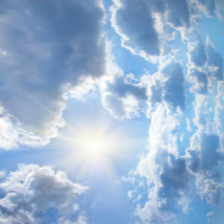

Prediction   : Cloudy (0.5952)
Ground Truth : Shine


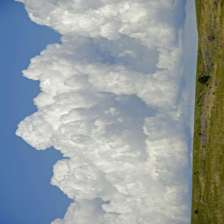

Prediction   : Shine (0.5124)
Ground Truth : Cloudy


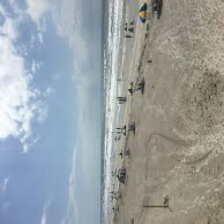

Prediction   : Rain (0.5594)
Ground Truth : Shine


In [ ]:
from IPython.display import display
from PIL import Image
FP = 3
for data in test_dl:
    if FP==0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if FP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p!=g:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            FP -= 1


#### True Positive Cases (Low confidence, Edge case)

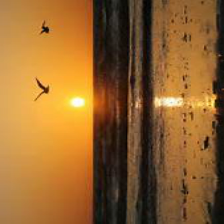

Prediction   : Sunrise (0.6086)
Ground Truth : Sunrise


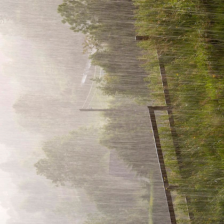

Prediction   : Rain (0.6026)
Ground Truth : Rain


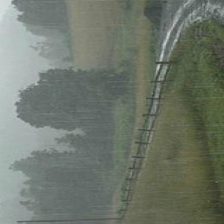

Prediction   : Rain (0.5871)
Ground Truth : Rain


In [ ]:
TP = 3
for data in test_dl:
    if TP <= 0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if TP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p==g and conf < 0.7:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            TP -= 1